In [ ]:
%pip install wget numpy IPython opencv-python matplotlib tensorflow pillow Flask

In [ ]:
%pip install tf_slim

In [2]:
import os
import wget
import numpy as np
from IPython.display import display
import cv2
from six import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont

In [3]:
CUSTOM_MODEL_NAME = "my_ssd_mobnet"
PRETRAINED_MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
PRETRAINED_MODEL_URL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
TF_RECORD_SCRIPT_NAME = "generate_tfrecord.py"
LABEL_MAP_NAME = "label_map.pbtxt"

In [4]:
paths = {
    "WORKSPACE_PATH": os.path.join("Tensorflow", "workspace"),
    "SCRIPTS_PATH": os.path.join("Tensorflow", "scripts"),
    "APIMODEL_PATH": os.path.join("Tensorflow", "models"),
    "ANNOTATION_PATH": os.path.join("Tensorflow", "workspace", "annotations"),
    "IMAGE_PATH": os.path.join("Tensorflow", "workspace", "images"),
    "MODEL_PATH": os.path.join("Tensorflow", "workspace", "models"),
    "PRETRAINED_MODEL_PATH": os.path.join("Tensorflow", "workspace", "pre-trained-models"),
    "CHECKPOINT_PATH": os.path.join("Tensorflow", "workspace", "models", CUSTOM_MODEL_NAME),
    "OUTPUT_PATH": os.path.join("Tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "export"),
    "TFJS_PATH": os.path.join("Tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "tfjsexport"),
    "TFLITE_PATH": os.path.join("Tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "tfliteexport"),
    "PROTOC_PATH": os.path.join("Tensorflow", "protoc"),
    "EXPORT_MODEL": os.path.join("Tensorflow", "workspace", "export_model"),
}

In [5]:
files = {
    "PIPELINE_CONFIG": os.path.join("Tensorflow", "workspace", "models", CUSTOM_MODEL_NAME, "pipeline.config"),
    "TF_RECORD_SCRIPT": os.path.join(paths["SCRIPTS_PATH"], TF_RECORD_SCRIPT_NAME),
    "LABELMAP": os.path.join(paths["ANNOTATION_PATH"], LABEL_MAP_NAME),
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
            !mkdir -p {path}

In [6]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [7]:
# Install Tensorflow Object Detection 
url="https://github.com/protocolbuffers/protobuf/releases/download/v22.5/protoc-22.5-win64.zip"
wget.download(url)
!move protoc-22.5-win64.zip {paths['PROTOC_PATH']}
!cd {paths['PROTOC_PATH']} && tar -xf protoc-22.5-win64.zip
os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
!cd Tensorflow/models/research/slim && pip install -e . 


        1 file(s) moved.
        1 file(s) copied.
running build
running build_py
copying object_detection\protos\anchor_generator_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\argmax_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\bipartite_matcher_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\box_predictor_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\calibration_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\center_net_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\eval_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_box_coder_pb2.py -> build\lib\object_detection\protos
copying object_detection\protos\faster_rcnn_pb2.py -> build\lib\object_detection\protos
copying object_detecti

d:\Dev\ptit-embedded-system\Server\tfod\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
d:\Dev\ptit-embedded-system\Server\tfod\lib\site-packages\setuptools\command\easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.densepose_ops.cpython-310: module references __file__
object_detection.core.__pycache__.preprocessor.cpython-310: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-310: module MAY be using inspect.stack
d:\Dev\ptit-embedded-system\Server\tfod\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning:  is an invalid version and will not be supported in a future release
  warnings.warn(
d:\

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [6]:
# Các hàm inference

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_util


def run_inference_for_single_image(model, image):
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]

    model_fn = model.signatures["serving_default"]
    output_dict = model_fn(input_tensor)

    num_detections = int(output_dict.pop("num_detections"))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict["num_detections"] = num_detections
    output_dict["detection_classes"] = output_dict["detection_classes"].astype(np.int64)

    if "detection_masks" in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict["detection_masks"], output_dict["detection_boxes"], image.shape[0], image.shape[1]
        )
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict["detection_masks_reframed"] = detection_masks_reframed.numpy()

    return output_dict


def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, "rb").read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [7]:
# Load model
tf.keras.backend.clear_session()
model = tf.saved_model.load(os.path.join(paths["EXPORT_MODEL"], "saved_model"))
model = model.signatures["serving_default"]

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(files["LABELMAP"], use_display_name=True)

In [9]:
# pool_labels = ['person', 'bicycle', 'car','motorcycle','airplane','bus','train','truck','bench','bird','cat','dog','chair', 'toilet', 'tv', 'book']
pool_labels_ids = list(map(lambda item: item["id"], list(category_index.values())))
focus_length = 2  # MP
# centimeter
label_id_with_known_width = {
    1: [45, 46],
    2: [56, 71],
    3: [150, 180],
    4: [60, 90],
    5: [240, 610],
    6: [240, 320],
    7: [340, 430],
    8: [180, 210],
    15: [180, 210],
    16: [25, 76],
    17: [23, 30],
    18: [30, 35],
    62: [41, 46],
    70: [36, 46],
    72: [81, 140],
    84: [10, 15],
}
print(list(category_index.values()))
print(list(pool_labels_ids))

[{'id': 1, 'name': 'person'}, {'id': 2, 'name': 'bicycle'}, {'id': 3, 'name': 'car'}, {'id': 4, 'name': 'motorcycle'}, {'id': 5, 'name': 'airplane'}, {'id': 6, 'name': 'bus'}, {'id': 7, 'name': 'train'}, {'id': 8, 'name': 'truck'}, {'id': 15, 'name': 'bench'}, {'id': 16, 'name': 'bird'}, {'id': 17, 'name': 'cat'}, {'id': 18, 'name': 'dog'}, {'id': 62, 'name': 'chair'}, {'id': 70, 'name': 'toilet'}, {'id': 72, 'name': 'tv'}, {'id': 84, 'name': 'book'}]
[1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 18, 62, 70, 72, 84]


In [10]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = model(input_tensor)
    num_detections = int(output_dict.pop("num_detections"))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict["num_detections"] = num_detections
    output_dict["detection_classes"] = output_dict["detection_classes"].astype(np.int64)

    if "detection_masks" in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict["detection_masks"], output_dict["detection_boxes"], image.shape[0], image.shape[1]
        )
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict["detection_masks_reframed"] = detection_masks_reframed.numpy()

    return output_dict

In [11]:
def distance_finder(focus_length, real_width, width_in_frame):
    distance = (real_width * focus_length) / width_in_frame

    # return the distance
    return distance

# Test on image


In [12]:
def show_inference(model, image_path):
    image_np = np.array(Image.open(image_path))
    output_dict = run_inference_for_single_image(model, image_np)
    boxes = []
    classes = []
    scores = []
    distances = []
    for i, x in enumerate(output_dict["detection_classes"]):
        if x in pool_labels_ids and output_dict["detection_scores"][i] > 0.5:
            _x, _y, _w, _h = output_dict["detection_boxes"][i]
            distance_min = int(distance_finder(focus_length, label_id_with_known_width[x][0], _w))
            distance_max = int(distance_finder(focus_length, label_id_with_known_width[x][1], _w))
            distances.append([_x, _y, distance_min])

            cv2.putText(image_np, str(distance_min), (30, 35), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 255, 0), 2)

            classes.append(x)
            boxes.append(output_dict["detection_boxes"][i])
            scores.append(output_dict["detection_scores"][i])
    boxes = np.array(boxes)
    classes = np.array(classes)
    scores = np.array(scores)
    viz_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=output_dict.get("detection_masks_reframed", None),
        use_normalized_coordinates=True,
        line_thickness=2,
    )

    display(Image.fromarray(image_np))
    return distances

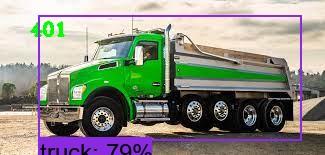

[[0.103881836, 0.117849976, 401]]

In [13]:
image_path = "./images/truck.png"
show_inference(model, image_path)

In [13]:
def make_infer(model, image_np):
    output_dict = run_inference_for_single_image(model, image_np)
    boxes = []
    classes = []
    scores = []
    distances = []
    for i, x in enumerate(output_dict["detection_classes"]):
        if x in pool_labels_ids and output_dict["detection_scores"][i] > 0.5:
            _x, _y, _w, _h = output_dict["detection_boxes"][i]
            print("bbox", output_dict["detection_boxes"][i])
            distance_min = int(distance_finder(focus_length, label_id_with_known_width[x][0], _w))
            distance_max = int(distance_finder(focus_length, label_id_with_known_width[x][1], _w))
            distances.append((_x, _y, _w, _h, distance_min))

            classes.append(x)
            boxes.append(output_dict["detection_boxes"][i])
            scores.append(output_dict["detection_scores"][i])
    boxes = np.array(boxes)
    classes = np.array(classes)
    scores = np.array(scores)
    viz_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=output_dict.get("detection_masks_reframed", None),
        use_normalized_coordinates=True,
        line_thickness=1,
    )
    return distances

# Real Time Detections from your Webcam


In [ ]:
import math

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    image_np = np.array(frame)
    distances = make_infer(model, image_np)

    if ret == True:
        for _x, _y, _w, _h, distance_min in distances:
            cv2.putText(
                image_np,
                str(distance_min),
                (math.ceil(_x * 100), math.ceil(_y * 100) + int(_h * 100)),
                cv2.FONT_HERSHEY_COMPLEX,
                0.6,
                (0, 255, 0),
                2,
            )
            print(distance_min)
        cv2.imshow("Frame", image_np)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord("q"):
            break

cv2.destroyAllWindows()
cap.release()